## Projet de NLP


##### Ce jupyter notebook prermet de tester le code qui a été mise en oeuvre pour évaluer nous différentes approches

Comme présenté dans notre rapport, plusieurs méthode ont été utilisée pour faire le resumé de document :


1. **Méthode utilisant les mots-clés pour obtenir le résumé du document** : nous déterminons les poids tf-idf de chaque mot dans une phrase du document, puis nous trouvons le poids définitif de chaque mot dans le document en faisant la somme des poids des mots dans chaque document où il intervient. Ensuite, nous trions ces mots-clés et prenons les top_n mots qui ont les meilleurs scores. Le document résumé est celui dont la somme des scores des mots parmi les n_top mots-clés est maximale.
2. **Méthode utilisant BERT** : ici, nous utilisons le modèle BERT pour obtenir un embedding de chaque phrase du document. Ensuite, nous faisons la moyenne des embeddings pour obtenir l'embedding du document. Le mot qui résume le mieux le document est celui dont le vecteur est le plus proche, en utilisant la similarité cosinus du vecteur du document.
3. **Méthode utilisant TF-IDF et la sémantique avec FastText** : Dans cette méthode, nous utilisons FastText pour réaliser un embedding sémantique des mots, puis nous regroupons sémantiquement les mots en clusters en nous basant sur leur signification. Pour le regroupement, nous appliquons un seuil avec l'algorithme DBSCAN. Une fois que les clusters ont été construits, nous calculons les scores TF-IDF de chaque cluster dans un document, en considérant la somme des scores TF-IDF de chaque mot appartenant au cluster. Une fois les scores TF-IDF de chaque cluster dans les documents calculés, nous identifions les clusters les plus pertinents en cherchant ceux dont la somme des poids dans tous les documents est maximale. Une fois ces n_top_clusters sélectionnés, les meilleurs documents sont ceux dont la somme des scores TF-IDF des mots présents dans le cluster est maximale.
4. Nous avons également plusieurs variantes du modèle RoberTa tel que expliqué dans le rapport.


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.code.tools.preprocessing_gpu import TextPreprocessor
from src.code.tools.metrics import get_bert_score
import fasttext.util
import numpy as np
import os
from src.code.TF_IDF_Fasttext.dbscan import DBSCAN
from src.code.TFIDF.pre_processing import Processing
from src.code.bert.bert import Bert
from dotenv import load_dotenv
import glob
from concurrent.futures import ProcessPoolExecutor, as_completed
import cupy as cp
import gc
from nltk.tokenize import sent_tokenize
from src.code.Roberta.roberta import DocumentProcessor
load_dotenv()
ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
processor_roberta = DocumentProcessor(
    n_grams=2, min_n_gram_freq=1, stop_words=['example', 'stopword'])
tf_idf_keyword_process = Processing()
processor = TextPreprocessor()
tf_idf_fasttext_process = DBSCAN(eps=0.4, model=ft)


def process_tf_idf_key_word(documents, tokens, tf_idf_dict, top_n):
    top_doc_indices_keywords = tf_idf_keyword_process.get_resume_docs_index(
        top_n=top_n, number_key_words=30, tokens=tokens, tf_idf_dict=tf_idf_dict)
    return "TF_IDF_KEY_WORD", "\n".join(documents[top_doc_indices_keywords[0:top_n]])


def process_tf_idf_fasttext(documents, tokens, tf_idf_dict, top_n):
    best_resumes_index = tf_idf_fasttext_process.get_resumes_doc(
        top_n=2, n_clusters=3, tokens=tokens, tf_idf_dict=tf_idf_dict)
    return "TF_IDF_FASTTEXT", "\n".join(documents[best_resumes_index[0:top_n]])


def process_bert(documents, top_n):
    bert = Bert(documents=documents)
    bert.processing()
    top_doc_indices_bert, resume_doc_bert = bert.get_resume(top_n=top_n)
    return "BERT", "\n".join(documents[top_doc_indices_bert[0:top_n]])


def process_roberta(documents):
    resultats = processor_roberta.process_document(documents=documents)
    return "ROBERTA", resultats

In [14]:

def get_resume_by_method(documents, top_n, tokens, tf_idf_dict):
    best_resumes_method = {}

    with ProcessPoolExecutor(max_workers=16) as executor:
        futures = {
            executor.submit(process_roberta, documents): "ROBERTA",
            executor.submit(process_tf_idf_key_word, documents, tokens, tf_idf_dict, top_n): "TF_IDF_KEY_WORD",
            executor.submit(process_tf_idf_fasttext, documents, tokens, tf_idf_dict, top_n): "TF_IDF_FASTTEXT",
            executor.submit(process_bert, documents, top_n): "BERT",

        }

        for future in as_completed(futures):
            method_name, result = future.result()
            if method_name == "ROBERTA":
                for k, v in result.items():
                    best_resumes_method[k] = v
            else:
                best_resumes_method[method_name] = result

    return best_resumes_method

In [19]:
results_methodes = {
    "TF_IDF_KEY_WORD": 1,
    "TF_IDF_FASTTEXT": 2,
    "BERT": 3,
    "method1": 4,
    "method2": 5,
    "hybrid": 6
}


def get_best_method(n_documents, top_n):
    n_docs = len(glob.glob(os.path.join(
        os.getenv('TXT_FOLDER'), "*.txt"))[0:n_documents])
    F1_all = np.zeros((len(results_methodes.keys()), n_docs), dtype=float)
    P_all = np.zeros_like(F1_all)
    R_all = np.zeros_like(F1_all)
    index_with_not_value = []

    for idx, file in enumerate(tqdm(glob.glob(os.path.join(os.getenv('TXT_FOLDER'), "*.txt"))[0:n_docs+1])):
        with open(file, "r", encoding="utf-8") as f:
            doc = f.read().strip().lower()
            if len(doc) > 10:
                try:
                    documents = np.array(sent_tokenize(doc))
                    tokens, tf_idf_dict = processor.preprocess(documents)
                    resultats_ = get_resume_by_method(
                        documents, top_n=top_n, tokens=tokens, tf_idf_dict=tf_idf_dict)
                    sorted_keys = sorted(resultats_, key=results_methodes.get)
                    sorted_values = [resultats_[key] for key in sorted_keys]
                    P, R, F1 = get_bert_score(
                        sorted_values, [doc] * (len(results_methodes.keys())))
                    F1 = F1.numpy()
                    P = P.numpy()
                    R = R.numpy()
                    F1_all[:, idx] += F1
                    P_all[:, idx] += P
                    R_all[:, idx] += R
                    del documents, tokens, tf_idf_dict, resultats_
                    cp.get_default_memory_pool().free_all_blocks()
                    gc.collect()  # Forcer le ramassage des ordures
                except Exception as e:
                    print(f"Error processing {file}: {e}")
                    index_with_not_value.append(idx)

    return P_all, R_all, F1_all, index_with_not_value

In [58]:
processor_roberta = DocumentProcessor(
    n_grams=2, min_n_gram_freq=1, stop_words=['example', 'stopword'])
tf_idf_keyword_process = Processing()
processor = TextPreprocessor()
tf_idf_fasttext_process = DBSCAN(eps=0.22, model=ft)

In [59]:
def get_best_method_old(methodes, n_documents, top_n):
    n_docs = len(glob.glob(os.path.join(
        os.getenv('TXT_FOLDER2'), "*.txt"))[0:n_documents])
    index_with_not_value = []
    document = ""

    for idx, file in enumerate(tqdm(glob.glob(os.path.join(os.getenv('TXT_FOLDER2'), "*.txt"))[0:n_docs+1])):
        with open(file, "r", encoding="utf-8") as f:
            doc = f.read().strip().lower()
            document += "\n"+doc
    if len(document) > 10:
        try:
            document = document.lower()
            documents = np.array(sent_tokenize(document))
            tokens, tf_idf_dict = processor.preprocess(documents)
            a, b = tf_idf_fasttext_process.get_clusters(tokens, tf_idf_dict)
            return a, b
        except Exception as e:
            print(f"Error processing {file}: {e}")
            index_with_not_value.append(idx)

    return None

In [ ]:
# L'exécution de cette cellule permet d'avoir les résultats d'évaluation des différentes approches sur le dataset


P, R, F1, index_with_not_value = get_best_method(569, 1)

In [ ]:
# Si vous souhaitez juste charger les resultats déjà enregistré et les visualiser, décommenter ces lignes de codes et exécuter les :
""" F1 = np.load("F1.npy")
P = np.load("P.npy")
R = np.load("R.npy") """

' F1 = np.load("F1.npy")\nP = np.load("P.npy")\nR = np.load("R.npy") '

In [ ]:
#

def get_rank_matrix(A):
    """
    This function calculates the rank matrix of a given 2D array.
    Parameters:
    A (numpy.ndarray): A 2D array of shape (m, n) where m is the number of rows and n is the number of columns.
    Returns:
    B (numpy.ndarray): A 2D array of shape (m, n) representing the rank matrix of A.
        The value at B[i, j] represents the rank of A[i, j] in the j-th column of A.
        The rank is calculated based on the descending order of the values in each column.
    """
    B = np.zeros_like(A)
    for j in range(A.shape[1]):
        sorted_indices = np.argsort(-A[:, j])
        ranks = np.zeros_like(sorted_indices)
        ranks[sorted_indices] = np.arange(len(sorted_indices))
        B[:, j] = ranks
    return B


rangs = get_rank_matrix(F1)
rangs = rangs+1

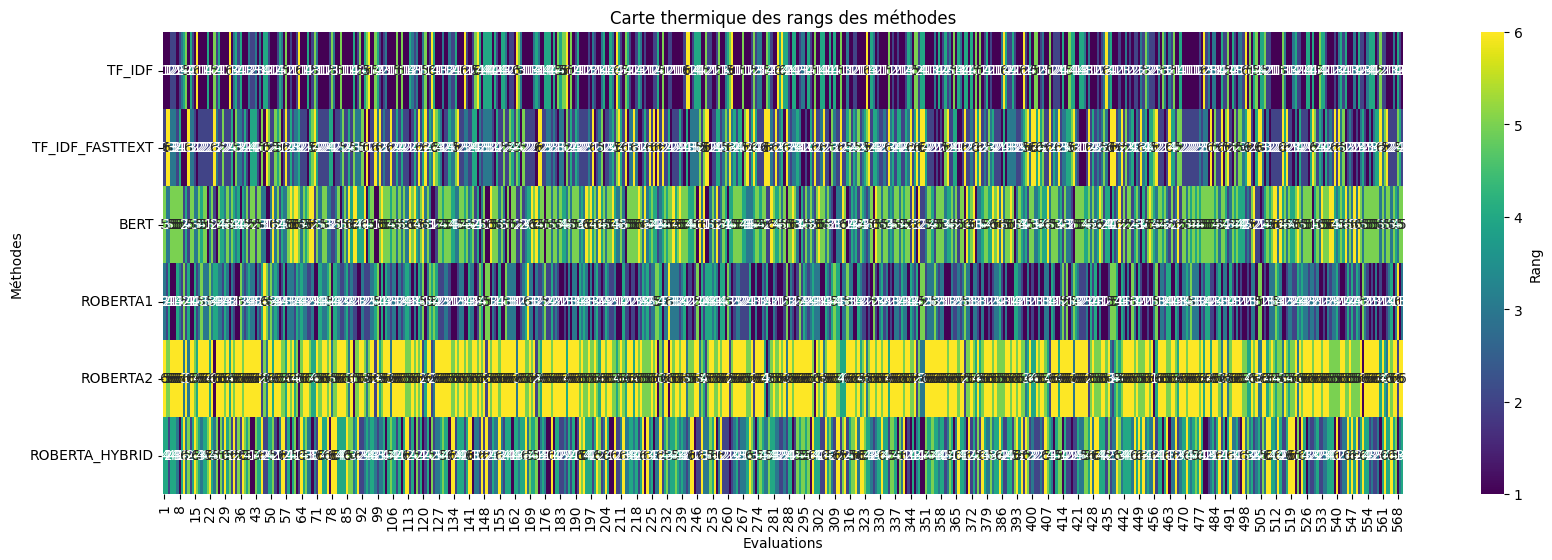

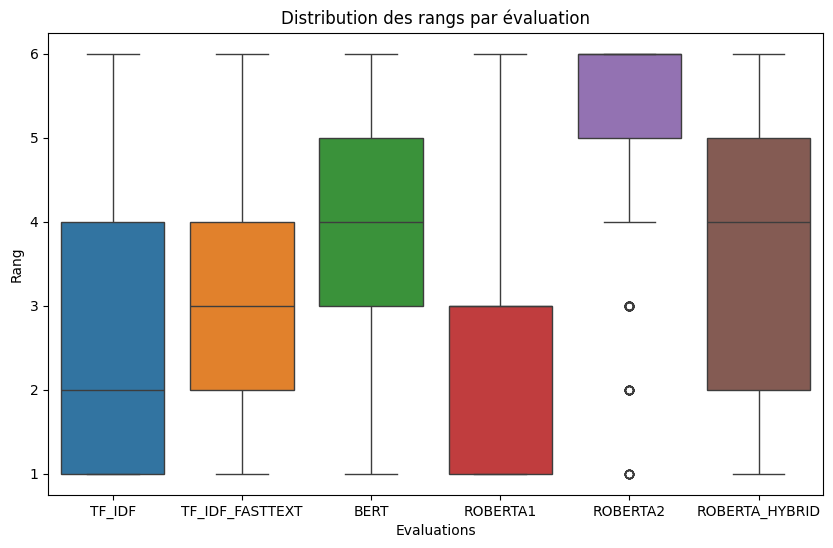

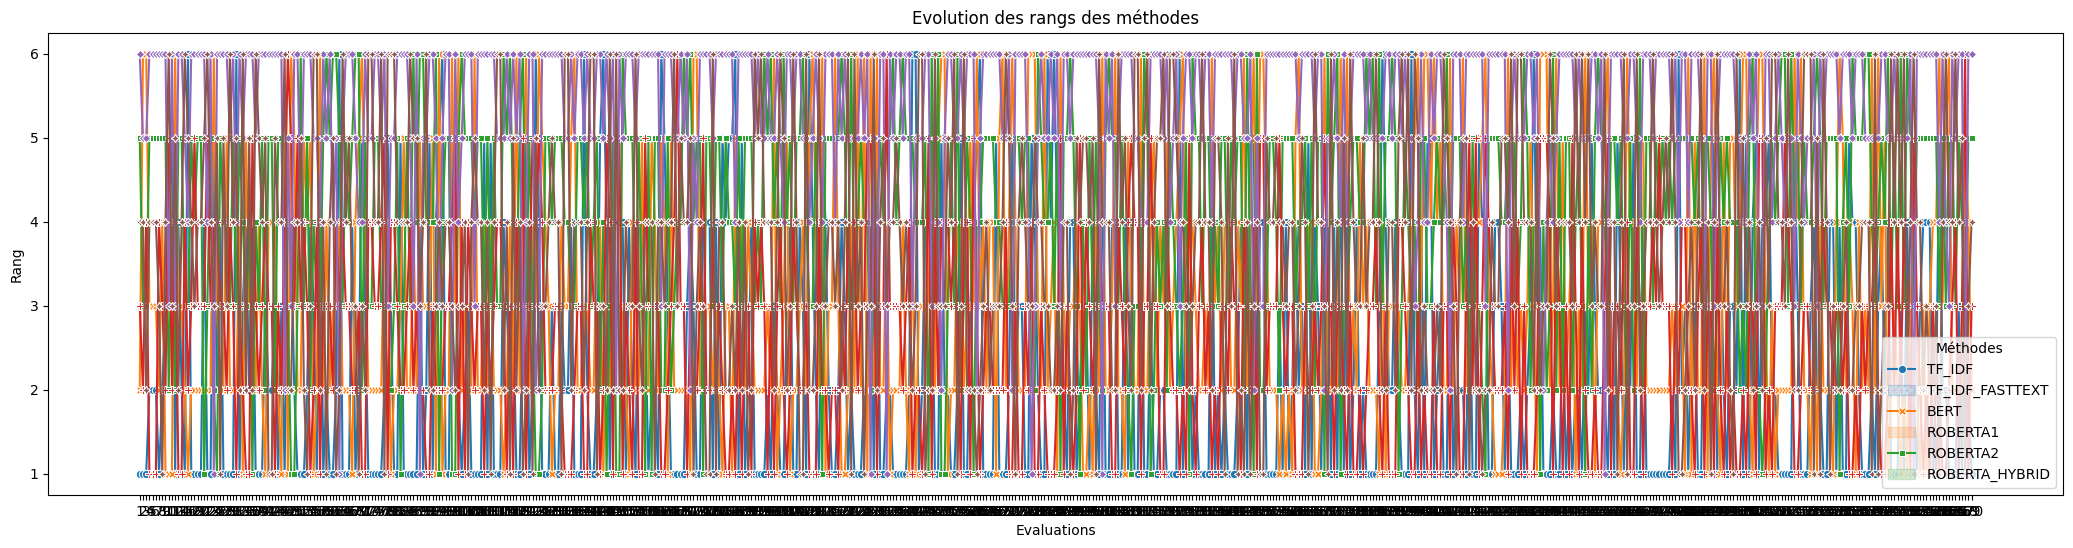

In [ ]:


# Visualisation des résultats : Carte thermique des rangs de méthodes
data = rangs

df = pd.DataFrame(data, columns=[str(i+1) for i in range(data.shape[1])],
                  index=['TF_IDF', 'TF_IDF_FASTTEXT', 'BERT', 'ROBERTA1', "ROBERTA2", "ROBERTA_HYBRID"])

plt.figure(figsize=(20, 6))
sns.heatmap(df, annot=True, cmap='viridis', cbar_kws={'label': 'Rang'})
plt.title('Carte thermique des rangs des méthodes')
plt.ylabel('Méthodes')
plt.xlabel('Evaluations')
plt.show()

# Affichage d'un Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.T)
plt.title('Distribution des rangs par évaluation')
plt.ylabel('Rang')
plt.xlabel('Evaluations')
plt.show()

# Affichage d'un Lineplot
plt.figure(figsize=(26, 6))
sns.lineplot(data=df.T, markers=True, dashes=False)
plt.title('Evolution des rangs des méthodes')
plt.ylabel('Rang')
plt.xlabel('Evaluations')
plt.legend(title='Méthodes', labels=df.index)
plt.show()

<Figure size 800x400 with 0 Axes>

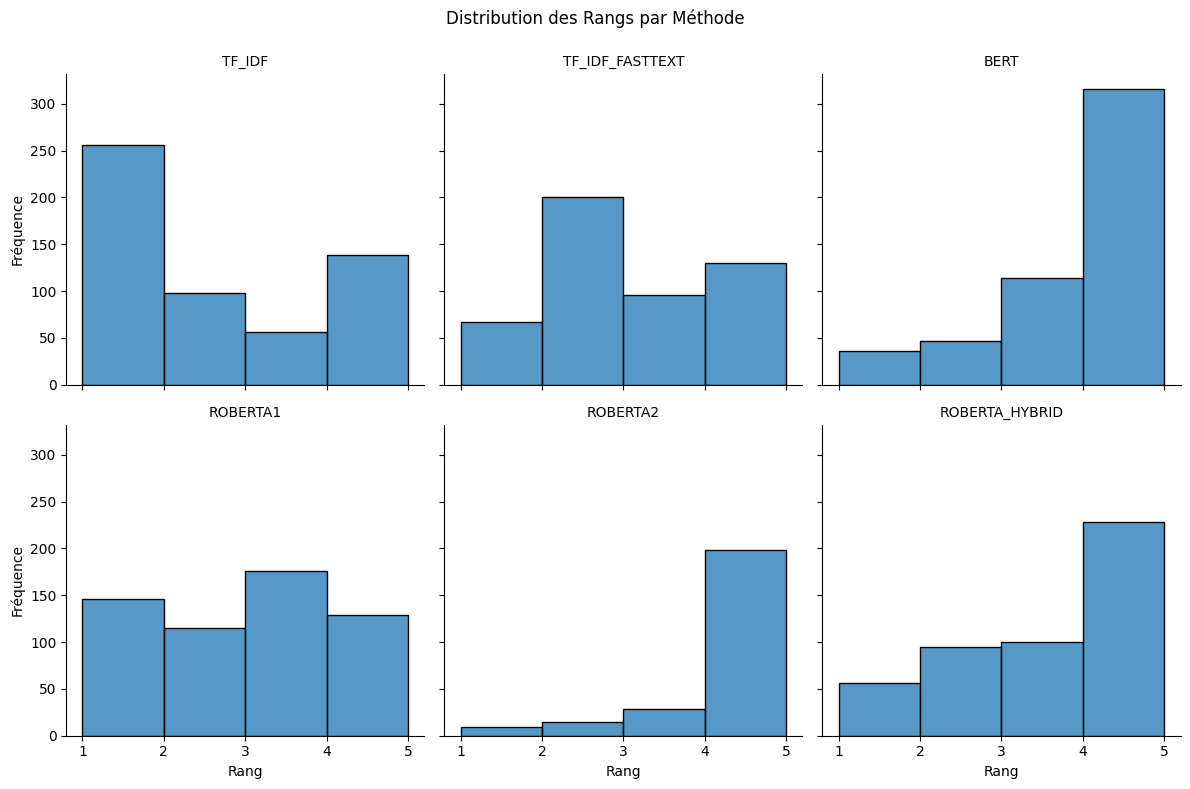

In [ ]:
# Distribution des rangs
data = rangs.T
df = pd.DataFrame(data, columns=[
                  'TF_IDF', 'TF_IDF_FASTTEXT', 'BERT', 'ROBERTA1', 'ROBERTA2', 'ROBERTA_HYBRID'])

df_melted = df.melt(var_name='Méthode', value_name='Rang')
df_melted.shape

plt.figure(figsize=(8, 4))
g = sns.FacetGrid(df_melted, col='Méthode', col_wrap=3, height=4)
g.map(sns.histplot, 'Rang', bins=range(1, 6), kde=False)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Rang", "Fréquence")
g.set(xticks=range(1, 6))

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution des Rangs par Méthode')
plt.show()

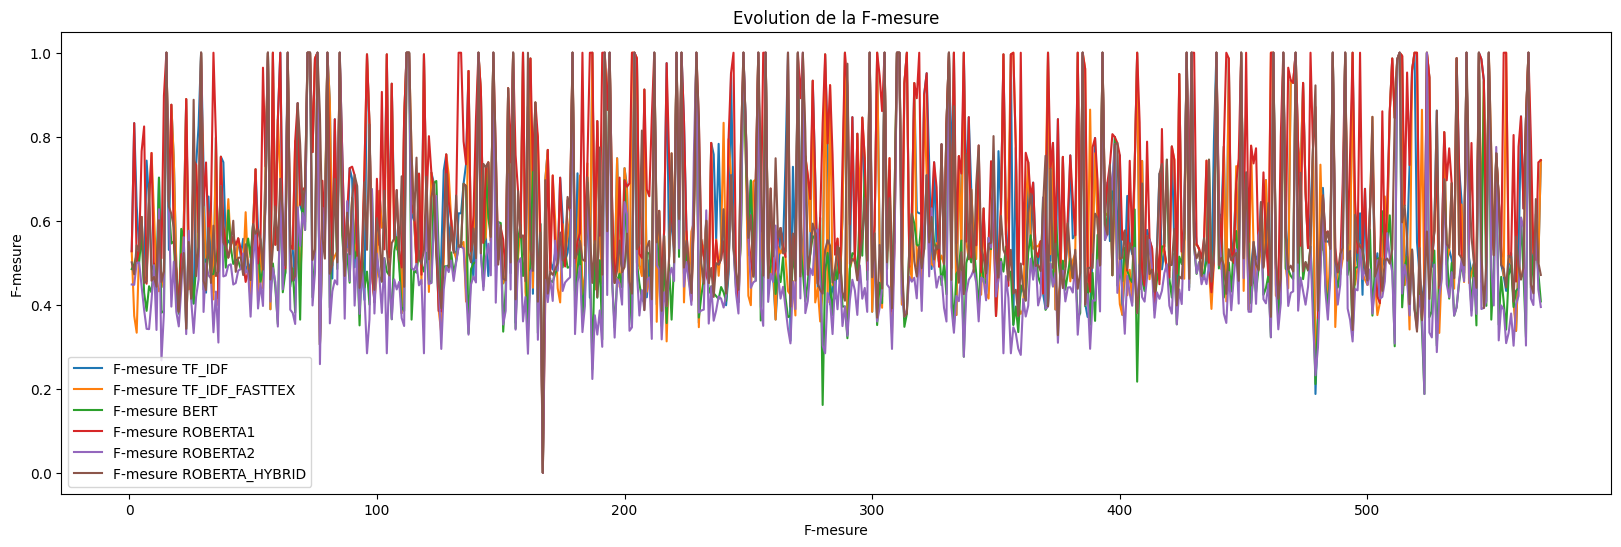

In [ ]:
# Evolution de la F1-mesure
data = F1
plt.figure(figsize=(20, 6))
plt.plot(range(1, 571), F1[0, :], label="F-mesure TF_IDF")
plt.plot(range(1, 571), F1[1, :], label="F-mesure TF_IDF_FASTTEX")
plt.plot(range(1, 571), F1[2, :], label="F-mesure BERT")
plt.plot(range(1, 571), F1[3, :], label="F-mesure ROBERTA1")
plt.plot(range(1, 571), F1[4, :], label="F-mesure ROBERTA2")
plt.plot(range(1, 571), F1[5, :], label="F-mesure ROBERTA_HYBRID")
plt.title('Evolution de la F-mesure')
plt.ylabel('F-mesure')
plt.xlabel('F-mesure')
plt.legend()